# A comparison of model SSH and tidal gauge data

In [36]:
import subprocess
import os

import netCDF4
import numpy as np
import glob
import time
import matplotlib.pyplot as plt
import copy
import xarray as xr
from datetime import datetime, timedelta 
from roms_regrid import *
from celluloid import Camera 
import cartopy.crs as ccrs
import seawater as sw
import pandas as pd

In [37]:
import pandas as pd
import xarray as xr

# Read file
f='/home/x-uheede/R/HAFRO/Grundartangi_01012024-30122024.xlsx'
grundartangi = pd.read_excel(f, decimal=',')

# Parse time
time = grundartangi['Timabil'].str.strip()
time = pd.to_datetime(time, format="%H:%M\n%d.%m.%Y", dayfirst=True)

# Replace column
grundartangi['time'] = time

# Set time as index (optional but recommended)
grundartangi = grundartangi.set_index('time')

# Convert to xarray
ds = xr.Dataset.from_dataframe(grundartangi)
ds = ds.sortby("time")
ds


<xarray.Dataset> Size: 5MB
Dimensions:               (time: 52561)
Coordinates:
  * time                  (time) datetime64[ns] 420kB 2024-01-01 ... 2024-12-31
Data variables:
    Timabil               (time) object 420kB '00:00 01.01.2024 ' ... '00:00 ...
    Flodtafla (m)         (time) float64 420kB 2.56 2.46 2.36 ... 1.01 0.97 0.93
    Sj (m)                (time) float64 420kB 2.9 2.83 2.73 ... -3.73 -3.73
    Vindur (m/s)          (time) int64 420kB 1 1 1 1 2 1 1 3 ... 7 8 7 8 8 8 8 8
    Hvidda (m/s)          (time) int64 420kB 1 2 2 2 2 2 2 ... 9 9 9 10 10 10 9
    Vindatt               (time) int64 420kB 57 356 354 341 37 ... 59 58 58 59
    Loftværstingur (hpa)  (time) int64 420kB 998 998 998 998 ... 1013 1013 1013
    Lofthiti ©            (time) float64 420kB -4.0 -5.2 -4.7 ... -5.1 -4.5 -4.6
    Sjavarhiti ©          (time) float64 420kB 2.1 2.1 2.1 2.2 ... 1.5 1.6 1.7
    Selta (PSU)           (time) float64 420kB 20.54 20.52 20.53 ... 20.05 20.05
    Unnamed: 10           (time) object 420kB '  ' '  ' '  ' ... '  ' '  ' '  '

In [38]:
grundartangi

,Timabil,Flodtafla (m),Sj (m),Vindur (m/s),Hvidda (m/s),Vindatt,Loftværstingur (hpa),Lofthiti ©,Sjavarhiti ©,Selta (PSU),Unnamed: 10
time,,,,,,,,,,,
2024-12-31 00:00:00,00:00 31.12.2024,0.93,-3.73,8,9,59,1013,-4.6,1.7,20.05,
2024-12-30 23:50:00,23:50 30.12.2024,0.97,-3.73,8,10,58,1013,-4.5,1.6,20.05,
2024-12-30 23:40:00,23:40 30.12.2024,1.01,-3.73,8,10,58,1013,-5.1,1.5,20.05,
2024-12-30 23:30:00,23:30 30.12.2024,1.07,-3.73,8,10,59,1013,-4.8,1.5,20.05,
2024-12-30 23:20:00,23:20 30.12.2024,1.13,-3.73,8,9,57,1013,-4.7,1.5,20.05,
...,...,...,...,...,...,...,...,...,...,...,...
2024-01-01 00:40:00,00:40 01.01.2024,2.16,2.52,2,2,37,998,-3.0,2.2,20.55,
2024-01-01 00:30:00,00:30 01.01.2024,2.26,2.63,1,2,341,998,-4.1,2.2,20.55,
2024-01-01 00:20:00,00:20 01.01.2024,2.36,2.73,1,2,354,998,-4.7,2.1,20.53,


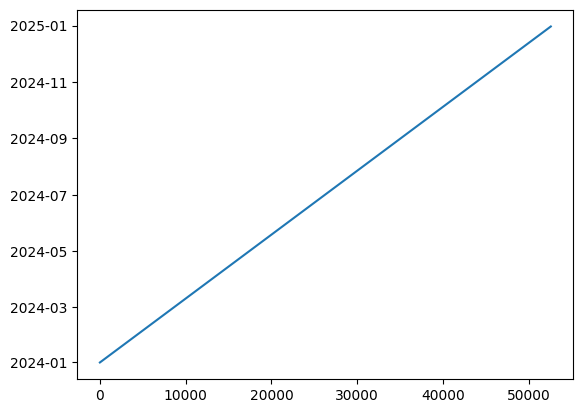

In [39]:
plt.plot(ds.time)

In [51]:

model_grid_path="/home/x-uheede/S/Iceland2_MARBL_2024_60m/P_INPUT/Iceland2_grid_MAT1.nc"
# Grid parameters, only modify these if grid is made in MATLAB
vert_levels=60
theta_s_model=5
theta_b_model=2
hc_model=300
model_data_path="/anvil/scratch/x-uheede/Iceland2_NOMARBL_2024_RHALF/Iceland2_MARBL_2024_his.20240?????????.nc"


In [52]:
from roms_tools import Grid, ROMSOutput
grid = Grid.from_file(
    model_grid_path
)


2025-12-09 14:53:09 - WARNING - Vertical coordinates (Cs_r, Cs_w) not found in grid file.
2025-12-09 14:53:09 - INFO - === Preparing the vertical coordinate system using N = 100, theta_s = 5.0, theta_b = 2.0, hc = 300.0 ===
2025-12-09 14:53:09 - INFO - Total time: 0.004 seconds
2025-12-09 14:53:09 - INFO - ================================================================================================


In [53]:
#Only run this cell if grid is made in MATLAB
grid.update_vertical_coordinate(N=vert_levels, theta_s=theta_s_model, theta_b=theta_b_model, hc=hc_model, verbose=False)

In [54]:
import xarray as xr
import numpy as np
target_depth_levels=[1,2,3,4,5,7,9,10,12,14,15,16,18,20,26,30,36,40,50,80] # Specify depth levels of interest
# Load ROMS output using your pattern
roms_output = ROMSOutput(
    grid=grid,
    path=[
        model_data_path,
    ],
    use_dask=True,
)

ds_model = roms_output.regrid(var_names=["zeta"])

In [55]:
ds_model.load()

<xarray.Dataset> Size: 7GB
Dimensions:  (time: 5002, lat: 481, lon: 721)
Coordinates:
  * time     (time) datetime64[ns] 40kB 2024-02-01T12:00:00 ... 2024-08-27T04...
  * lat      (lat) float32 2kB 63.0 63.0 63.01 63.01 ... 64.99 64.99 65.0 65.0
  * lon      (lon) float32 3kB 336.0 336.0 336.0 336.0 ... 339.0 339.0 339.0
Data variables:
    zeta     (time, lat, lon) float32 7GB nan nan nan nan ... nan nan nan nan
Attributes: (12/45)
    global_x:           512
    global_y:           512
    title:              Iceland2_MARBL_2024 , 200 m  resolution
    grid_file:          /anvil/scratch/x-uheede/Iceland2_MARBL_2024_60m/P_INP...
    forcing_files:       /anvil/scratch/x-uheede/Iceland2_MARBL_2024_60m/P_IN...
    forcing_info:       
    ...                 ...
    river_frc_options:  OFF
    pipe_frc_options:   OFF
    particle_options:   OFF
    git_version:        
    type:               ROMS history file
    regrid_method:      bilinear

In [57]:
# Identify duplicates in the time coordinate
duplicates = ds_model['time'].to_index().duplicated()

# Drop duplicate time steps
ds_model_unique = ds_model.sel(time=~duplicates)


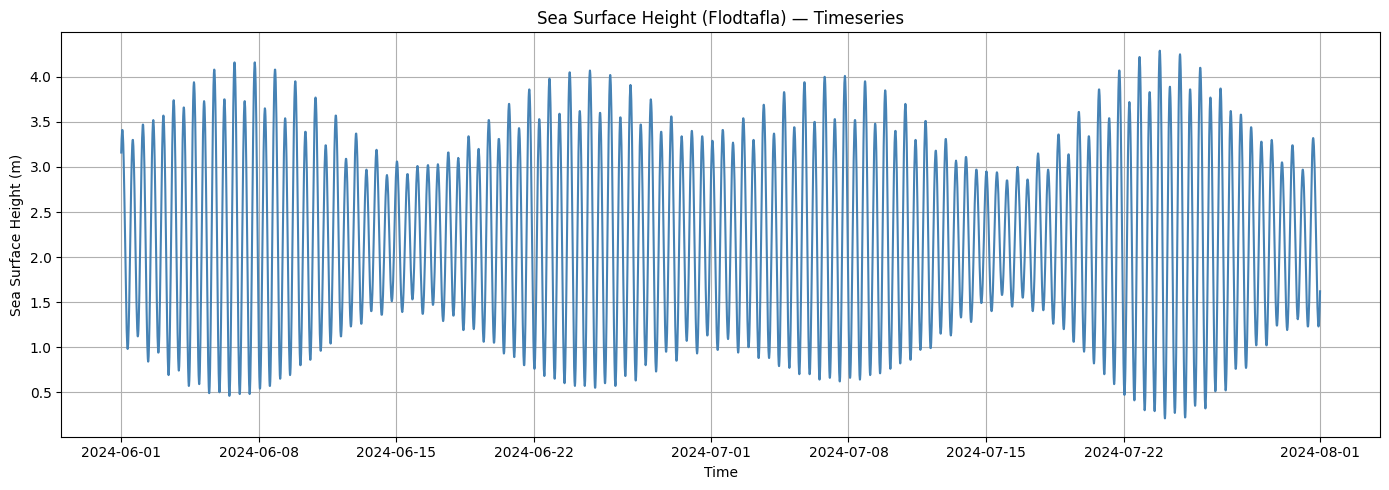

In [45]:
plt.figure(figsize=(14,5))
plt.plot(ds["time"].sel(time=slice('2024-06-01','2024-07-31')), ds["Flodtafla (m)"].sel(time=slice('2024-06-01','2024-07-31')), color="steelblue")
plt.title("Sea Surface Height (Flodtafla) — Timeseries")
plt.xlabel("Time")
plt.ylabel("Sea Surface Height (m)")
plt.grid(True)
plt.tight_layout()
plt.show()

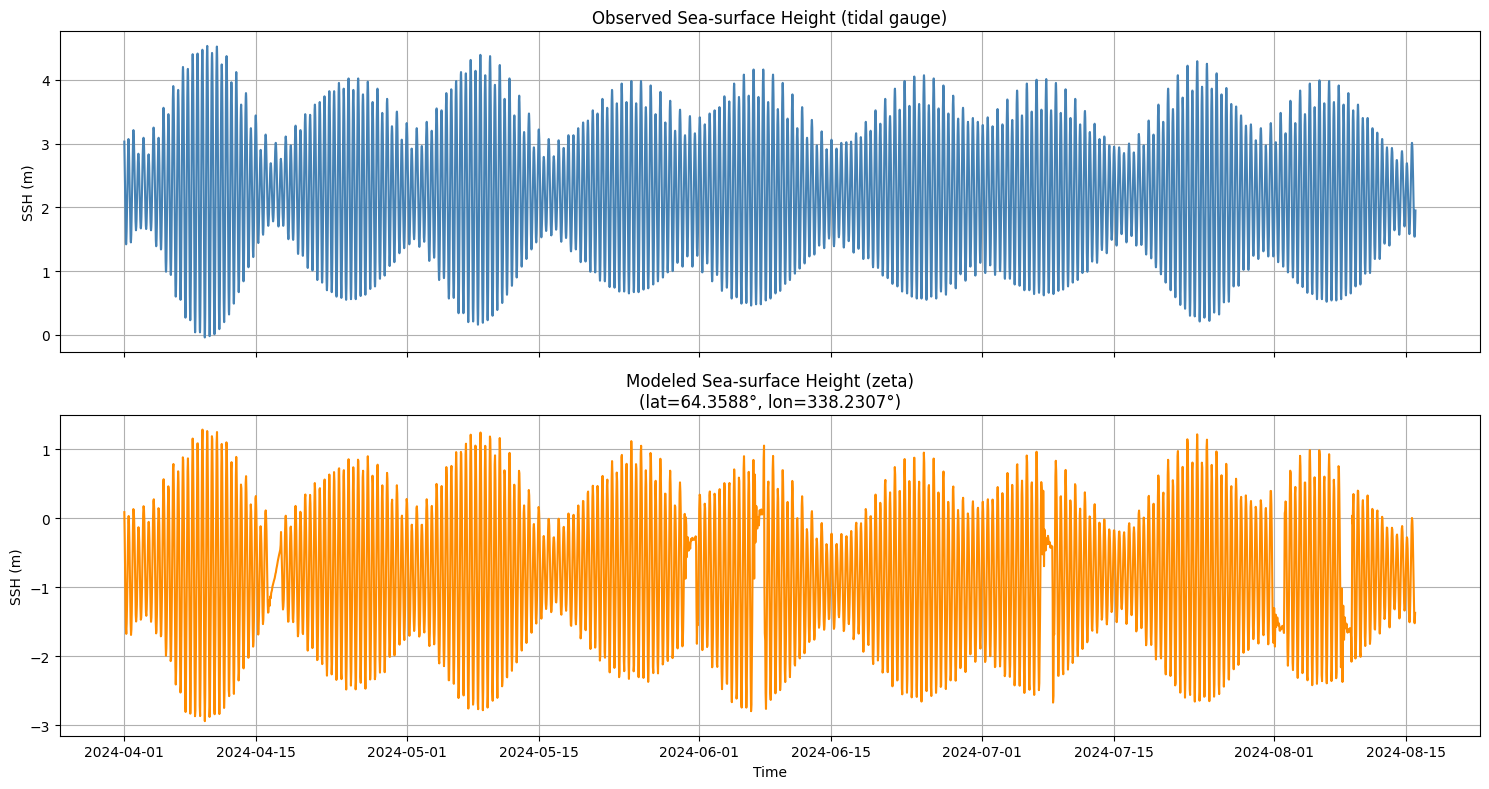

In [62]:
import matplotlib.pyplot as plt

#64.358799°N 21.769334°W

# Convert lon_W to 0–360 range
lon_target = 360 - 21.769334   # = 338.2242
lat_target = 64.358799

# Select nearest model grid point for zeta
zeta_point = ds_model_unique["zeta"].sel(
    lon=lon_target, 
    lat=lat_target, 
    method="nearest"
)

# Select same time window
t0, t1 = "2024-04-01", "2024-08-15"

ssh_obs = ds["Flodtafla (m)"].sel(time=slice(t0, t1))
ssh_time = ds["time"].sel(time=slice(t0, t1))

zeta_mod = zeta_point.sel(time=slice(t0, t1))


# -------------------------------
# 2-panel figure
# -------------------------------
fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(15, 8), sharex=True,
    gridspec_kw={"height_ratios": [1, 1]}
)

# -------------------------------------
# Panel 1 — Observed Flodtafla
# -------------------------------------
ax1.plot(ssh_time, ssh_obs, color="steelblue")
ax1.set_title("Observed Sea-surface Height (tidal gauge)")
ax1.set_ylabel("SSH (m)")
ax1.grid(True)

# -------------------------------------
# Panel 2 — Modeled zeta
# -------------------------------------
ax2.plot(zeta_mod["time"], zeta_mod, color="darkorange")
ax2.set_title(
    f"Modeled Sea-surface Height (zeta)\n(lat={lat_target:.4f}°, lon={lon_target:.4f}°)"
)
ax2.set_ylabel("SSH (m)")
ax2.set_xlabel("Time")
ax2.grid(True)

plt.tight_layout()
plt.show()


Mean observed SSH  : 2.244110401459855
Mean modeled SSH   : -0.8107247948646545
Vertical offset Δ  : 3.0548351963245097


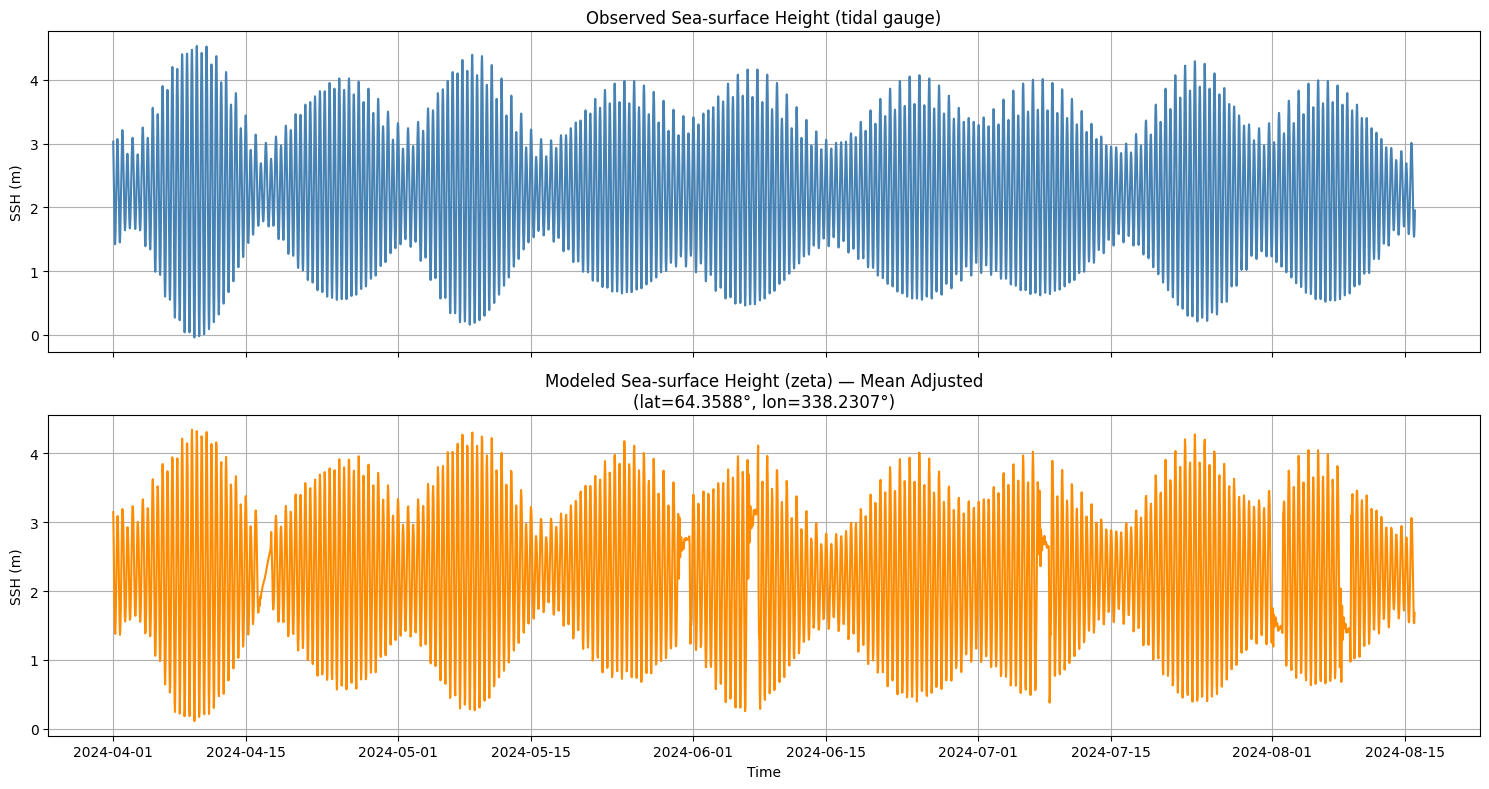

In [63]:
import matplotlib.pyplot as plt

# 64.358799°N 21.769334°W

# Convert lon_W to 0–360 range
lon_target = 360 - 21.769334   # = 338.230666
lat_target = 64.358799

# Select nearest model grid point for zeta
zeta_point = ds_model_unique["zeta"].sel(
    lon=lon_target, 
    lat=lat_target, 
    method="nearest"
)

# Select same time window
t0, t1 = "2024-04-01", "2024-08-15"

ssh_obs = ds["Flodtafla (m)"].sel(time=slice(t0, t1))
ssh_time = ds["time"].sel(time=slice(t0, t1))

zeta_mod = zeta_point.sel(time=slice(t0, t1))


# --------------------------------------------------------
# Compute mean SSH for observations and model
# --------------------------------------------------------
mean_obs = float(ssh_obs.mean())
mean_mod = float(zeta_mod.mean())

# Compute offset so means match
offset = mean_obs - mean_mod

print("Mean observed SSH  :", mean_obs)
print("Mean modeled SSH   :", mean_mod)
print("Vertical offset Δ  :", offset)

# Apply correction
zeta_mod_corrected = zeta_mod + offset


# --------------------------------------------------------
# Plot 2-panel figure
# --------------------------------------------------------
fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(15, 8), sharex=True,
    gridspec_kw={"height_ratios": [1, 1]}
)

# -------------------------------------
# Panel 1 — Observed Flodtafla
# -------------------------------------
ax1.plot(ssh_time, ssh_obs, color="steelblue")
ax1.set_title("Observed Sea-surface Height (tidal gauge)")
ax1.set_ylabel("SSH (m)")
ax1.grid(True)

# -------------------------------------
# Panel 2 — Modeled zeta (mean-corrected)
# -------------------------------------
ax2.plot(zeta_mod_corrected["time"], zeta_mod_corrected, color="darkorange")
ax2.set_title(
    f"Modeled Sea-surface Height (zeta) — Mean Adjusted\n"
    f"(lat={lat_target:.4f}°, lon={lon_target:.4f}°)"
)
ax2.set_ylabel("SSH (m)")
ax2.set_xlabel("Time")
ax2.grid(True)

plt.tight_layout()
plt.show()
